In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
import optuna
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import gc

## Data preprocessing and some EDA

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cerenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_excel('/home/cerenov/PROJECTS/glow/dataset.xlsx')
df.shape

(53198, 3)

In [4]:
df.drop_duplicates(subset = ['text'],inplace = True)
df.shape

(47973, 3)

In [5]:
df.head()

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport


По данной визуализации можно заметить, что класс extreme и hockey имеют заметно меньше экземпляров относительно других классов.

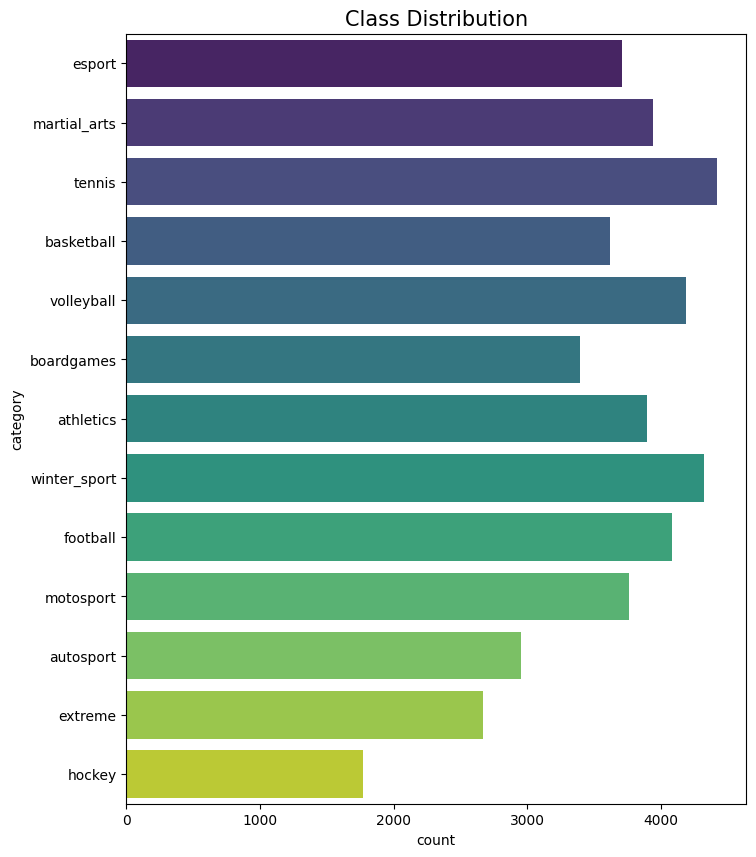

In [108]:
plt.figure(figsize=(8, 10))
sns.countplot(y='category', palette='viridis', data=df,legend=False,hue='category')
plt.title('Class Distribution', size=15)
plt.show()

In [9]:
def get_top_ngrams(corpus, ngram_range, stop_words=None, n=None):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)
        
    df = pd.DataFrame({'Слова': words, 'Частота': freqs})
    return df

In [121]:
stop_words = None
n = 20
unigrams = get_top_ngrams(df['text'], (1, 1), stop_words, n)

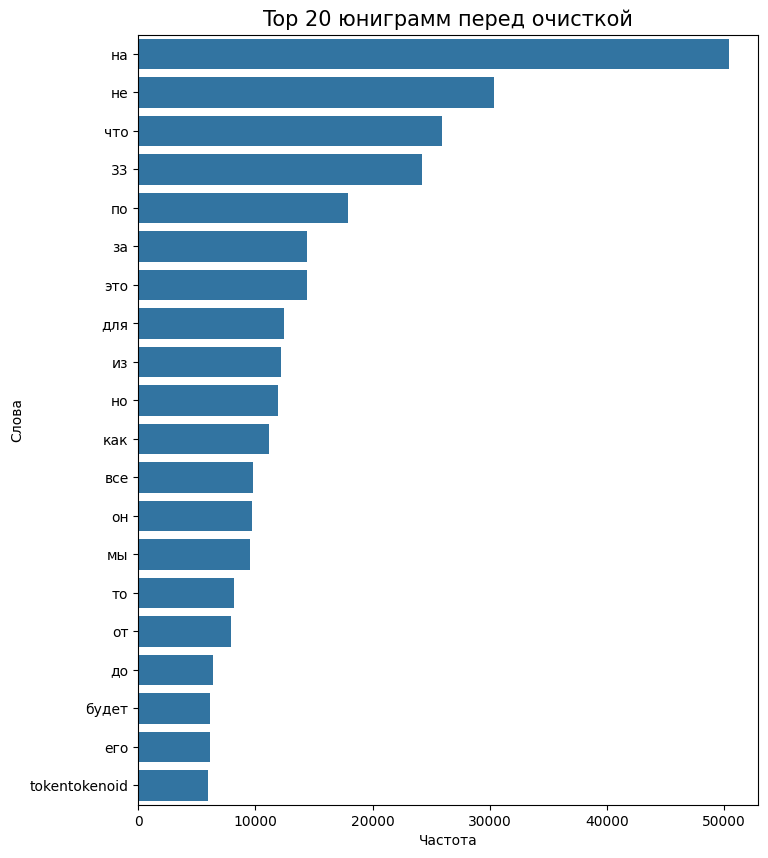

In [124]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Частота', y='Слова', data=unigrams)
plt.title('Top 20 юниграмм перед очисткой', size=15)
plt.show()

Удаляем стоп слова и лемматизируем

In [6]:
mystem = Mystem()
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text
df['clean_text'] = df['text'].apply(preprocess_text)

In [7]:
df.drop(index = 0,inplace = True)
df.reset_index(drop = True,inplace = True)

In [10]:
stop_words = None
n = 20
unigrams = get_top_ngrams(df['clean_text'], (1, 1), stop_words, n)

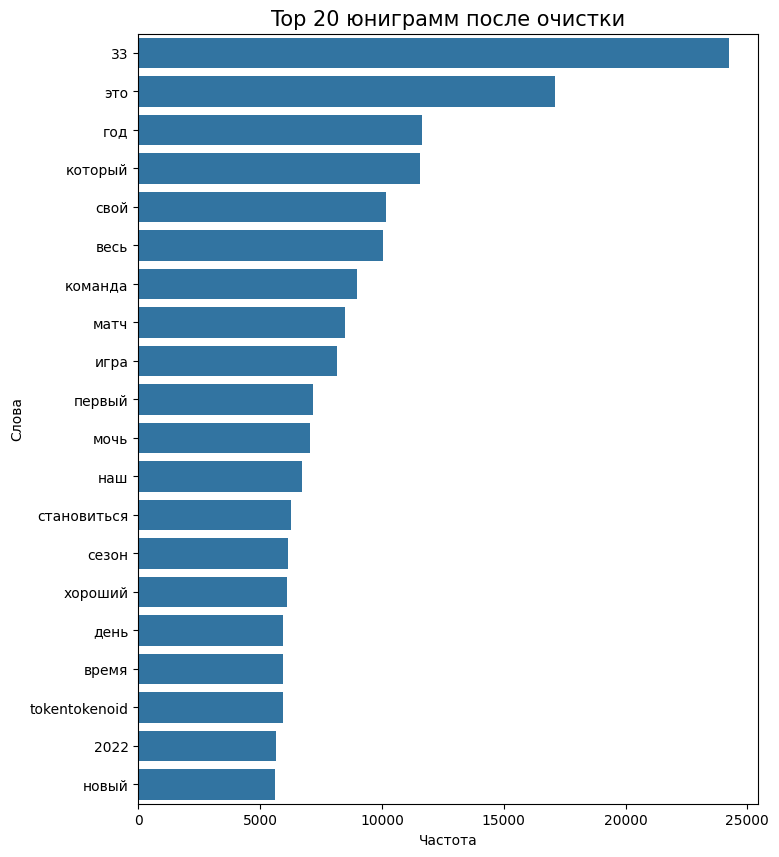

In [126]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Частота', y='Слова', data=unigrams)
plt.title('Top 20 юниграмм после очистки', size=15)
plt.show()

## Vectorize data and target encoding

In [15]:
vect = TfidfVectorizer()
le = LabelEncoder()

In [16]:
df_vect = vect.fit_transform(df['clean_text'])
target = le.fit_transform(df['category'])

In [73]:
df_vect.shape

(46712, 80669)

In [12]:
tsvd = TruncatedSVD(n_components=50)
x_vec = tsvd.fit_transform(df_vect)

In [15]:

tsne = TSNE(n_components=3)
x_vec = tsne.fit_transform(x_vec)

In [23]:
def plot_embeddings(text_corpus):
    '''3д визуализация векторизации предложений'''
    fig = plt.figure(figsize = [10,10])
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(text_corpus[:,0],text_corpus[:,1],text_corpus[:,2],c = target,label = df.category)
    legend = ax.legend(*[scatter.legend_elements()[0],df.category.unique()],)
    plt.show()


Визуализация пространства признаков относительно меток класса.

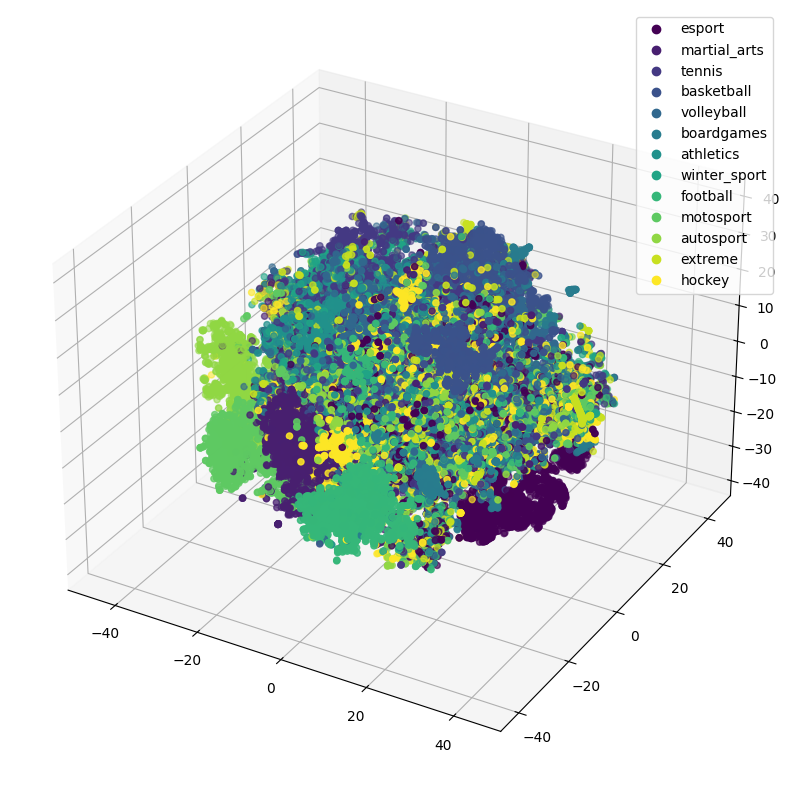

In [24]:
plot_embeddings(x_vec)

## Baseline model

In [74]:
# split data
x_train,x_test,y_train,y_test = train_test_split(df_vect,target,test_size=0.2,random_state=42,stratify=target,shuffle=True)

In [75]:
baseline = MultinomialNB()
baseline.fit(x_train,y_train)
y_pred = baseline.predict(x_test)
print(classification_report(y_test,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

   athletics       0.75      0.90      0.82       779
   autosport       0.98      0.74      0.84       590
  basketball       0.91      0.83      0.87       724
  boardgames       0.86      0.93      0.89       679
      esport       0.84      0.80      0.82       742
     extreme       0.90      0.48      0.62       534
    football       0.84      0.81      0.82       817
      hockey       1.00      0.32      0.49       354
martial_arts       0.85      0.78      0.81       788
   motosport       0.85      0.90      0.88       751
      tennis       0.90      0.96      0.93       883
  volleyball       0.73      0.90      0.81       838
winter_sport       0.69      0.94      0.80       864

    accuracy                           0.82      9343
   macro avg       0.85      0.79      0.80      9343
weighted avg       0.84      0.82      0.82      9343



In [31]:
# немного прочищаем данные
query = [
    'hr',
    'вакансия',
    'курсовая',
    'рассрочка',
    'кредитка',
    'элайнер',
    'промокод',
    'коллектор',
    'менеджер',
    'маркетплейс',
    'автокредит',
    'бровина',
    'договорный матч',
    'мирный житель',
    'скриншот личка',
    'телегр канал',
    'клиент акция',
    'гараж снести'
    ]

In [32]:
for index,text in enumerate(df['clean_text']):
    t = text.split(' ')
    for w in range(1,len(t)):
        if t[w-1] +' '+ t[w] in query or t[-1] in query or t[w] in query:
            
            # print('start\n')
            # print(w)
            # print(text)
            # print('end\n')
            df.drop(df[df['clean_text'] == text].index,inplace = True) 

In [78]:
# df[df['category'] == 'extreme']['clean_text'].sample(12).to_list()

In [36]:
df_vect = vect.fit_transform(df['clean_text'])
target = le.fit_transform(df['category'])

In [80]:
x_train,x_test,y_train,y_test = train_test_split(df_vect,target,test_size=0.2,random_state=42,stratify=target,shuffle=True)

In [81]:
baseline = MultinomialNB()
baseline.fit(x_train,y_train)
y_pred = baseline.predict(x_test)
print(classification_report(y_test,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

   athletics       0.75      0.90      0.82       779
   autosport       0.98      0.74      0.84       590
  basketball       0.91      0.83      0.87       724
  boardgames       0.86      0.93      0.89       679
      esport       0.84      0.80      0.82       742
     extreme       0.90      0.48      0.62       534
    football       0.84      0.81      0.82       817
      hockey       1.00      0.32      0.49       354
martial_arts       0.85      0.78      0.81       788
   motosport       0.85      0.90      0.88       751
      tennis       0.90      0.96      0.93       883
  volleyball       0.73      0.90      0.81       838
winter_sport       0.69      0.94      0.80       864

    accuracy                           0.82      9343
   macro avg       0.85      0.79      0.80      9343
weighted avg       0.84      0.82      0.82      9343



## Models Ensemble

In [83]:
xgbs = XGBClassifier()

In [84]:
xgbs.fit(x_train,y_train)
y_pred = xgbs.predict(x_test)

In [85]:
print(classification_report(y_test,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

   athletics       0.90      0.84      0.87       778
   autosport       0.86      0.78      0.82       590
  basketball       0.90      0.81      0.85       724
  boardgames       0.92      0.90      0.91       678
      esport       0.56      0.80      0.66       742
     extreme       0.59      0.66      0.63       535
    football       0.77      0.81      0.79       816
      hockey       0.88      0.66      0.75       354
martial_arts       0.81      0.77      0.79       787
   motosport       0.88      0.85      0.87       751
      tennis       0.95      0.93      0.94       883
  volleyball       0.90      0.84      0.87       838
winter_sport       0.86      0.85      0.85       861

    accuracy                           0.82      9337
   macro avg       0.83      0.81      0.82      9337
weighted avg       0.83      0.82      0.82      9337



In [77]:
lr_params = {'tol': 0.0002679895298397021, 'C': 0.9877225852510577}

In [78]:
lr = LogisticRegression(**lr_params,random_state=42)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
print(classification_report(y_test,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

   athletics       0.92      0.87      0.89       778
   autosport       0.93      0.81      0.87       590
  basketball       0.91      0.85      0.88       724
  boardgames       0.94      0.93      0.93       678
      esport       0.74      0.86      0.80       742
     extreme       0.64      0.75      0.69       535
    football       0.82      0.86      0.84       816
      hockey       0.93      0.68      0.79       354
martial_arts       0.82      0.85      0.83       787
   motosport       0.92      0.90      0.91       751
      tennis       0.97      0.95      0.96       883
  volleyball       0.91      0.87      0.89       838
winter_sport       0.84      0.89      0.86       861

    accuracy                           0.86      9337
   macro avg       0.87      0.85      0.86      9337
weighted avg       0.87      0.86      0.86      9337



In [87]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)

In [88]:
print(classification_report(y_test,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

   athletics       0.67      0.88      0.76       778
   autosport       0.80      0.79      0.80       590
  basketball       0.79      0.84      0.81       724
  boardgames       0.84      0.92      0.88       678
      esport       0.81      0.73      0.77       742
     extreme       0.72      0.59      0.65       535
    football       0.82      0.77      0.79       816
      hockey       0.83      0.72      0.77       354
martial_arts       0.85      0.75      0.80       787
   motosport       0.84      0.87      0.86       751
      tennis       0.91      0.95      0.93       883
  volleyball       0.84      0.84      0.84       838
winter_sport       0.89      0.82      0.85       861

    accuracy                           0.82      9337
   macro avg       0.82      0.81      0.81      9337
weighted avg       0.82      0.82      0.82      9337



In [83]:
cb = CatBoostClassifier(verbose = 0,task_type='GPU',devices='0')

In [87]:
eclf = VotingClassifier(
    estimators=[('lr',lr),('xgb',xgbs),('nb',baseline)],
    voting='soft'
)

In [86]:
eclf.fit(x_train,y_train)

/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[21:50:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.9877225852510577,
                                                 random_state=42,
                                                 tol=0.0002679895298397021)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x7801bcde7d00>)],
                 voting='soft')

In [47]:
y_pred = eclf.predict(x_test)
print(classification_report(y_test,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

   athletics       0.88      0.89      0.88       792
   autosport       0.95      0.84      0.89       600
  basketball       0.94      0.83      0.88       733
  boardgames       0.93      0.95      0.94       709
      esport       0.73      0.86      0.79       794
     extreme       0.71      0.70      0.70       563
    football       0.83      0.85      0.84       832
      hockey       0.95      0.67      0.79       363
martial_arts       0.83      0.85      0.84       806
   motosport       0.92      0.91      0.91       770
      tennis       0.96      0.96      0.96       886
  volleyball       0.89      0.87      0.88       860
winter_sport       0.84      0.91      0.87       878

    accuracy                           0.87      9586
   macro avg       0.87      0.85      0.86      9586
weighted avg       0.87      0.87      0.87      9586



## Neural Net approach

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from tqdm.notebook import tqdm

Реализация небольшого конвейра обучения и тестирования.

In [34]:
device = 'cuda:0' if torch.cuda.is_available else 'cpu'

In [37]:
x_train,x_test,y_train,y_test = train_test_split(df['clean_text'],target,test_size=0.2,random_state=42,stratify=target,shuffle=True)

In [65]:
model_path = 'cointegrated/rubert-tiny2'
tokenizer_path = 'cointegrated/rubert-tiny2'

In [66]:
class Text_Dataset(Dataset):
    def __init__(self,X,y):
        self.X = X.values
        self.y = y
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        
        self.X = [self.tokenizer(seq,
                                 padding = 'max_length',
                                 max_length = 1024,
                                 truncation = True,
                                 return_tensors = 'pt') for seq in self.X]
        
    def __getitem__(self,index):
        x = self.X[index]
        y = self.y[index]

        return x,y
    
    def __len__(self,):
        return len(self.X)                

In [67]:
model = BertForSequenceClassification.from_pretrained(model_path)
model.classifier = nn.Linear(312,df['category'].nunique())
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,eta_min=1e-6)
loss_fn = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
train_ds = Text_Dataset(x_train,y_train)
test_ds = Text_Dataset(x_test,y_test)

In [69]:
N_EPOCHS = 5
BATCH_SIZE = 32

In [72]:
train_dataloader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,pin_memory=True,drop_last=True,num_workers=12)
test_dataloader = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,pin_memory=True,drop_last=False,num_workers=12)

In [73]:
torch.cuda.empty_cache()
gc.collect()

0

In [75]:

for epoch in tqdm(range(N_EPOCHS)):
    model.train()
    train_loss = 0
    prediction_labels = []
    test_labels = []
    for x,y in train_dataloader:
        optimizer.zero_grad()
        x_mask = x['attention_mask'].squeeze(dim=1).to(device)
        x_id = x['input_ids'].squeeze(dim=1).to(device)
        y = y.to(device)
        pred = model(x_id,x_mask)
        loss = loss_fn(pred[0],y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    scheduler.step()
    model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            x_mask = x['attention_mask'].squeeze(dim=1).to(device)
            x_id = x['input_ids'].squeeze(dim=1).to(device)
            y = y.to(device)
            pred = model(x_id,x_mask)
            prediction_labels.append(F.softmax(pred[0],dim=1).argmax(dim=1).detach().cpu().numpy())
            test_labels.append(y.detach().cpu().numpy())
    prediction_labels = np.concatenate(prediction_labels)
    test_labels = np.concatenate(test_labels)
    print(f'EPOCH: {epoch + 1} | Classification report:')
    print(classification_report(test_labels,prediction_labels,target_names=le.classes_))
    torch.save(model.state_dict(),f'/home/cerenov/PROJECTS/glow/logs/wights_{epoch}.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1 | Classification report:
              precision    recall  f1-score   support

   athletics       0.86      0.87      0.86       786
   autosport       0.88      0.79      0.83       595
  basketball       0.83      0.82      0.82       727
  boardgames       0.91      0.92      0.91       703
      esport       0.73      0.84      0.78       762
     extreme       0.60      0.62      0.61       549
    football       0.82      0.78      0.80       823
      hockey       0.83      0.70      0.76       355
martial_arts       0.85      0.76      0.80       791
   motosport       0.89      0.90      0.90       755
      tennis       0.94      0.94      0.94       884
  volleyball       0.80      0.86      0.83       846
winter_sport       0.83      0.86      0.84       867

    accuracy                           0.83      9443
   macro avg       0.83      0.82      0.82      9443
weighted avg       0.83      0.83      0.83      9443

EPOCH: 2 | Classification report:
           

## Вывод

На основании полученных результатов можно сказать, что можно добиться точности в предсказания 0.9+ ,очистив или обработав шумы в данных,проверить различные способы предобработки данных, проверить больше моделей и т.д.

## Hyperparameters search

Подборка гиперпараметров

In [ ]:
skf = StratifiedKFold(n_splits=10)

### Logistic regression

In [36]:
def br_objective(trial):
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1,log=True),
        "n_jobs" : -1
    }
    model = LogisticRegression(**params,random_state=42)
    cv_scores = cross_val_score(model,x_train,y_train,scoring = 'accuracy',cv=skf,n_jobs = -1)
    
    
    return np.mean(cv_scores)
    

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(br_objective,n_trials = 50,show_progress_bar = True)

[I 2024-07-27 20:38:28,594] A new study created in memory with name: no-name-4fd3ffa1-4f03-4d46-9e36-2274c5956e55


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-07-27 20:38:50,081] Trial 0 finished with value: 0.7308054673105998 and parameters: {'tol': 0.0007826471059611512, 'C': 0.034585326481838874}. Best is trial 0 with value: 0.7308054673105998.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:39:52,680] Trial 1 finished with value: 0.8458948582605782 and parameters: {'tol': 0.0009744967817629278, 'C': 0.47284401270015874}. Best is trial 1 with value: 0.8458948582605782.
[I 2024-07-27 20:40:43,458] Trial 2 finished with value: 0.8185373509102322 and parameters: {'tol': 0.00032629940957925734, 'C': 0.19839632894406356}. Best is trial 1 with value: 0.8458948582605782.
[I 2024-07-27 20:41:00,520] Trial 3 finished with value: 0.6681621381191685 and parameters: {'tol': 0.0005686385132320382, 'C': 0.016176292152977133}. Best is trial 1 with value: 0.8458948582605782.
[I 2024-07-27 20:41:20,242] Trial 4 finished with value: 0.7137494754611011 and parameters: {'tol': 0.0008050351259799111, 'C': 0.026571654254885044}. Best is trial 1 with value: 0.8458948582605782.
[I 2024-07-27 20:41:53,982] Trial 5 finished with value: 0.7686206650303093 and parameters: {'tol': 0.00038111205503414545, 'C': 0.06524341352882408}. Best is trial 1 with value: 0.8458948582605782.
[I 202

/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:43:26,451] Trial 7 finished with value: 0.8564571843636062 and parameters: {'tol': 0.0006873027229858208, 'C': 0.7441910760987708}. Best is trial 7 with value: 0.8564571843636062.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:44:29,176] Trial 8 finished with value: 0.830612178552021 and parameters: {'tol': 0.0003854260584532026, 'C': 0.27943100364430656}. Best is trial 7 with value: 0.8564571843636062.
[I 2024-07-27 20:44:42,264] Trial 9 finished with value: 0.6163417143937555 and parameters: {'tol': 0.0008107950703481459, 'C': 0.011089364159906868}. Best is trial 7 with value: 0.8564571843636062.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:45:45,160] Trial 10 finished with value: 0.8589086598396698 and parameters: {'tol': 2.980740423812455e-05, 'C': 0.8431254962194699}. Best is trial 10 with value: 0.8589086598396698.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:46:47,831] Trial 11 finished with value: 0.8598736141801313 and parameters: {'tol': 2.1381932107475965e-05, 'C': 0.8714364694130557}. Best is trial 11 with value: 0.8598736141801313.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:47:52,212] Trial 12 finished with value: 0.859247724504349 and parameters: {'tol': 3.0900987058671654e-06, 'C': 0.8559980667195752}. Best is trial 11 with value: 0.8598736141801313.
[I 2024-07-27 20:48:37,664] Trial 13 finished with value: 0.8050801617858194 and parameters: {'tol': 2.467510839177737e-06, 'C': 0.136948331343282}. Best is trial 11 with value: 0.8598736141801313.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:49:42,043] Trial 14 finished with value: 0.8385143494119383 and parameters: {'tol': 0.00016220693863788584, 'C': 0.3610147393345749}. Best is trial 11 with value: 0.8598736141801313.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:50:45,924] Trial 15 finished with value: 0.8615427598669422 and parameters: {'tol': 0.00014407293400255984, 'C': 0.9658066432725754}. Best is trial 15 with value: 0.8615427598669422.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:51:50,462] Trial 16 finished with value: 0.846416452260329 and parameters: {'tol': 0.00018724747807230384, 'C': 0.4812058020348866}. Best is trial 15 with value: 0.8615427598669422.
[I 2024-07-27 20:52:34,241] Trial 17 finished with value: 0.8016115739295495 and parameters: {'tol': 0.00016827923162623018, 'C': 0.12715206599589435}. Best is trial 15 with value: 0.8615427598669422.
[I 2024-07-27 20:53:32,791] Trial 18 finished with value: 0.823440315464665 and parameters: {'tol': 0.0002225600455549613, 'C': 0.2262007211442596}. Best is trial 15 with value: 0.8615427598669422.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:54:37,418] Trial 19 finished with value: 0.8492069855999194 and parameters: {'tol': 0.0005138534774350844, 'C': 0.5367606162186781}. Best is trial 15 with value: 0.8615427598669422.
[I 2024-07-27 20:55:12,708] Trial 20 finished with value: 0.7816865838422296 and parameters: {'tol': 0.00013135603751261382, 'C': 0.08281979738748697}. Best is trial 15 with value: 0.8615427598669422.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:56:11,820] Trial 21 finished with value: 0.8603691461628916 and parameters: {'tol': 6.77439849898047e-05, 'C': 0.9188762270941234}. Best is trial 15 with value: 0.8615427598669422.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:57:12,760] Trial 22 finished with value: 0.8621947931735472 and parameters: {'tol': 0.0002679895298397021, 'C': 0.9877225852510577}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:58:17,090] Trial 23 finished with value: 0.8519192648770113 and parameters: {'tol': 0.0002532773783872924, 'C': 0.5954922647681669}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 20:59:21,455] Trial 24 finished with value: 0.8368974501798565 and parameters: {'tol': 0.00010117792820849833, 'C': 0.34315012650224913}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:00:26,194] Trial 25 finished with value: 0.8505631490424997 and parameters: {'tol': 0.0002754493152597206, 'C': 0.568839611757958}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:01:31,555] Trial 26 finished with value: 0.8617775220544377 and parameters: {'tol': 9.289183829565073e-05, 'C': 0.9766096137213709}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:02:36,563] Trial 27 finished with value: 0.861933989372519 and parameters: {'tol': 0.0004330386796951167, 'C': 0.9861484358723692}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:03:40,926] Trial 28 finished with value: 0.8388794692924557 and parameters: {'tol': 0.0004254844591371194, 'C': 0.3668064496129252}. Best is trial 22 with value: 0.8621947931735472.
[I 2024-07-27 21:04:29,045] Trial 29 finished with value: 0.8131127107422167 and parameters: {'tol': 0.0004537027347264661, 'C': 0.16918003455201847}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:05:28,614] Trial 30 finished with value: 0.8307425770519588 and parameters: {'tol': 0.0006125578691333735, 'C': 0.28007290552686925}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:06:27,556] Trial 31 finished with value: 0.861986133809958 and parameters: {'tol': 0.0003078944461267351, 'C': 0.981173929584047}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:07:26,365] Trial 32 finished with value: 0.8537709330977414 and parameters: {'tol': 0.00030863312865738964, 'C': 0.6472349956325929}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:08:26,068] Trial 33 finished with value: 0.8432869290687386 and parameters: {'tol': 0.00047465738812833087, 'C': 0.4324580991190059}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:09:25,829] Trial 34 finished with value: 0.854553344500826 and parameters: {'tol': 0.0003652789454914899, 'C': 0.6664978761676147}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:10:25,862] Trial 35 finished with value: 0.8553096258753934 and parameters: {'tol': 0.00023367615891801993, 'C': 0.6908613558224296}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:11:24,795] Trial 36 finished with value: 0.8618557489123256 and parameters: {'tol': 0.0005316837921450488, 'C': 0.9947331734545315}. Best is trial 22 with value: 0.8621947931735472.
[I 2024-07-27 21:11:43,003] Trial 37 finished with value: 0.716696448914162 and parameters: {'tol': 0.0005405603957996824, 'C': 0.027560057762694296}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:12:43,560] Trial 38 finished with value: 0.843860667505929 and parameters: {'tol': 0.0005863247109837002, 'C': 0.44009366134237443}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:13:45,830] Trial 39 finished with value: 0.8552313854152003 and parameters: {'tol': 0.000623348723603084, 'C': 0.6848588153568412}. Best is trial 22 with value: 0.8621947931735472.
[I 2024-07-27 21:14:11,564] Trial 40 finished with value: 0.744027656207174 and parameters: {'tol': 0.0007454505302039055, 'C': 0.042539320567901835}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:15:12,454] Trial 41 finished with value: 0.8618035568668179 and parameters: {'tol': 0.00032289892468885295, 'C': 0.9813181557364358}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:16:13,739] Trial 42 finished with value: 0.8573178294257311 and parameters: {'tol': 0.00042171209262292986, 'C': 0.7665604033624145}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:17:14,727] Trial 43 finished with value: 0.861829666491877 and parameters: {'tol': 0.0003076258993671234, 'C': 0.988737158696663}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:18:15,568] Trial 44 finished with value: 0.8483724229582428 and parameters: {'tol': 0.00037271210129743423, 'C': 0.5145394619619474}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:19:16,624] Trial 45 finished with value: 0.8579437191015133 and parameters: {'tol': 0.0002958488185444353, 'C': 0.7850403180168279}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:20:17,649] Trial 46 finished with value: 0.8576307844653513 and parameters: {'tol': 0.00041261153151813925, 'C': 0.7771426765731353}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:21:17,697] Trial 47 finished with value: 0.851736728740787 and parameters: {'tol': 0.0009458965948628047, 'C': 0.5953477912904015}. Best is trial 22 with value: 0.8621947931735472.
[I 2024-07-27 21:21:34,209] Trial 48 finished with value: 0.6847488776397824 and parameters: {'tol': 0.0005019176230646717, 'C': 0.018940338619591233}. Best is trial 22 with value: 0.8621947931735472.


/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[I 2024-07-27 21:22:34,443] Trial 49 finished with value: 0.8408615700188868 and parameters: {'tol': 0.0006712793017684671, 'C': 0.3957536265794097}. Best is trial 22 with value: 0.8621947931735472.


{'n_estimators': 490,
 'max_depth': 29,
 'min_samples_split': 106,
 'min_samples_leaf': 2,
 'max_features': 15}